## ASSIGNMENT-2
Roll Numbers:

Names:

### Instructions
 * Fill in the roll numbers and names of all the teams members in the cell above.
 * Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
 * All the code and result files should be uploaded in the github classroom.
 * You can use the in-built methods and **unless explicitly mentioned**, don't need to code from scratch for this assignment. Make sure your code is modular since you will be reusing them for future assignments.
 * All the representations are expected to be in a right-hand coordinate system. All the functions related to transformation matrices, quaternions, and 3D projection are expected to be coded by you.
 * You could split the Jupyter Notebook cells where TODO is written, but please try to avoid splitting/changing the structure of other cells.
 * All the visualization should be done inside the notebook unless specified otherwise.
 * Plagiarism will lead to heavy penalty.

## G2O Motion Model 

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive nodes k and k+1.

## PART 2

### 1. ICP Alignment with LieTorch (5 marks)
Resources: https://github.com/princeton-vl/lietorch/tree/master

Perform ICP Alignment of 2 PointClouds using LieTorch. Similar to what was expected in Part 1, you will be given a random Transformation matrix from the getTransform function. You are expected to transform the Toothless Point Cloud by this transformation, add noise to both sets of points (original and transformed) and estimate both, the Transformation matrix and the original point cloud.

Visualize your results using open3d

In [63]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from lietorch import SE3, LieGroupParameter
import torch
import torch.optim as optim

def getTransform():
    euler_angles = torch.rand(3) * (1 * torch.pi)
    translation = torch.rand(3) * 100.0
    transformation_param = torch.cat((translation, euler_angles)).cuda()
    return SE3.exp(transformation_param)

37163.16015625
35413.86328125
33584.1328125
31698.1640625
29784.806640625
27878.728515625
26021.763671875
24264.255859375
22665.767578125
21293.9453125
20219.3671875
19502.72265625
19162.2734375
19105.34765625
19186.71875
19296.3125
19362.259765625
19344.67578125
19226.962890625
19008.498046875
18699.580078125
18318.3046875
17888.68359375
17439.23046875
17001.224609375
16605.546875
16276.203125
16018.46875
15808.1396484375
15605.0830078125
15379.73828125
15123.4521484375
14846.9521484375
14575.47265625
14342.162109375
14176.2158203125
14077.2255859375
14010.4970703125
13945.072265625
13871.041015625
13798.85546875
13754.5009765625
13769.3115234375
13805.896484375
13821.625
13806.5166015625
13772.2509765625
13741.2412109375
13726.8701171875
13712.04296875
13678.2392578125
13626.244140625
13572.3134765625
13535.318359375
13507.3759765625
13473.150390625
13438.673828125
13426.873046875
13423.0234375
13405.0595703125
13375.5146484375
13351.349609375
13334.8310546875
13309.45703125
13273.91

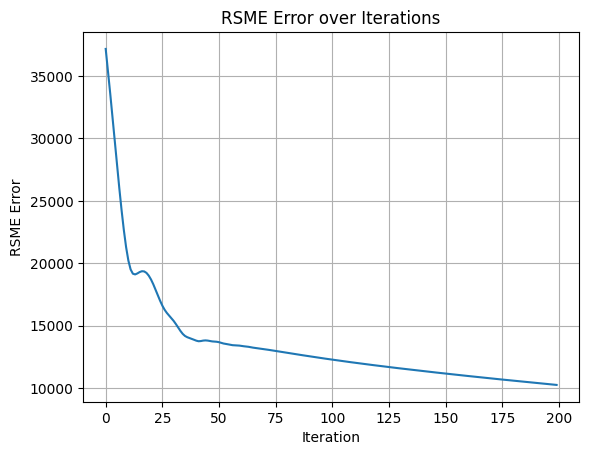

In [68]:
def transform_point_cloud(point_cloud, SE3_transform, downsample=1.0):
    if downsample < 1.0:
        indices = torch.arange(0, point_cloud.shape[0], int(1.0 / downsample))
        point_cloud = point_cloud[indices]
    
    transformation_matrix = SE3_transform.matrix()
    rotated_points = torch.matmul(point_cloud, transformation_matrix[:3, :3].T)
    transformed_points = rotated_points + transformation_matrix[:3, 3]
    
    return transformed_points

def compute_loss(pcl0, pcl1_transformed):
    residuals = (pcl1_transformed - pcl0).reshape(-1,1)
    loss = torch.norm(residuals, p=2)
    return loss

pcl = o3d.io.read_point_cloud('data/toothless.ply')
pcl_array = np.array(pcl.points)
pcl_tensor = torch.tensor(pcl_array, dtype=torch.float32).cuda()

transform0 = getTransform()
transform1 = getTransform()

downsample = 0.1
pcl0 = transform_point_cloud(pcl_tensor, transform0, downsample)
pcl1 = transform_point_cloud(pcl_tensor, transform1, downsample)

# Visualize point clouds
pcl0_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl0.cpu().numpy()))
frame0 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100.0, origin=[0, 0, 0])
frame_torch = torch.tensor(np.array(frame0.vertices), dtype=torch.float32).cuda()
pcl0_geom.paint_uniform_color([1.0, 0.0, 0.0])

pcl1_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl1.cpu().numpy()))
frame1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100.0, origin=[0, 0, 0])
pcl1_geom.paint_uniform_color([0.0, 0.0, 1.0])

vis = o3d.visualization.Visualizer()
vis.create_window()

vis.add_geometry(pcl0_geom)
vis.add_geometry(frame0)
vis.add_geometry(pcl1_geom)
vis.add_geometry(frame1)

vis.poll_events()
vis.update_renderer()
starting_pose = LieGroupParameter(getTransform())
optimizer = optim.Adam([starting_pose], lr=8e-2, weight_decay=1e-2)

errors = []

for i in range(200):
    optimizer.zero_grad()
    opti_transform = starting_pose.retr()
    pcl1_transformed = transform_point_cloud(pcl1, opti_transform)
    loss = compute_loss(pcl0, pcl1_transformed)
    loss.backward()
    torch.nn.utils.clip_grad_norm_([starting_pose], max_norm=10.0)
    optimizer.step()
    
    pcl1_geom.points = o3d.utility.Vector3dVector(pcl1_transformed.detach().cpu().numpy())
    frame1.vertices = o3d.utility.Vector3dVector(transform_point_cloud(frame_torch, opti_transform).detach().cpu().numpy())
    vis.update_geometry(pcl1_geom)
    vis.update_geometry(frame1)
    vis.poll_events()
    vis.update_renderer()
    error = loss.item()
    errors.append(error)
    
    if error < 2e2:
        pcl0_geom.paint_uniform_color([0.0, 1.0, 0.0])
        pcl1_geom.paint_uniform_color([0.0, 1.0, 0.0])
        vis.update_geometry(pcl0_geom)
        vis.update_geometry(pcl1_geom)
        print(f"Converged in {i} iterations with {error:.4f} error.")
        break

if error > 2e2:
    print("Failed to converge")

vis.run()
vis.destroy_window()

plt.plot(errors)
plt.xlabel('Iteration')
plt.ylabel('RSME Error')
plt.title('RSME Error over Iterations')
plt.grid()
plt.show()

### 2. ICP-SLAM with LieTorch (10 marks)

For this part, you will be given a set of `N` transformation matrices (Each relative to position 0). Add a random amount of noise to each of the `N` sets of points. Estimate the Transforms as well as the original point cloud using LieTorch.

Visualize your results using open3d

In [3]:
def getTransforms():
    # Output shape - (n, 4, 4)
    pass

In [4]:
'''
YOUR CODE HERE
'''

'\nYOUR CODE HERE\n'